## Understanding DCLP5 Dataset
This notebook tries provides details on the structure of the DCLP5 dataset and makes suggestions how to process the data.

## The DCLP5 study

**Title**: The International Diabetes Closed Loop (iDCL) trial: Clinical Acceptance of 
the Artificial Pancreas in Pediatrics - A Pivotal Study of t:slim X2 with Control-IQ Technology

**Description**: The objective of the study is to assess efficacy and safety of a closed loop control (CLC) system (t:slim X2 with Control-IQ Technology) in a randomized controlled trial with partial crossover.
    
**Devices**: t:slim X2 with Control-IQ and Dexcom G6 system

**Study Population**: Children aged 6 - 13 years old

# Data
The study data folder is named **DCLP5_Dataset_2022-01-20-5e0f3b16-c890-4ace-9e3b-531f3687cf53**

While there is a data glossary (DataGlossary_Dits.rtf) file, the file names within the glossary do not match the file names of the data. However, the column names do match and those definitions are listed below.

* **DCLP5TandemBolus_Completed_Combined_b.txt**: List of pupm data downloaded (bolus data only)
* **DCLP5TandemBASALRATECHG_b.txt**: List of pump data dowloaded (basal data only)
* **DCLP5TandemCGMDATAGXB_b.txt**: List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## DCLP5TandemBolus_Completed_Combined_b
* **PtID**: Patient ID
* **DataDtTm**: Date-time of delivered insulin
* **BolusAmount**: The amount of insulin actually delivered for this bolus
* **BolusType**: The bolus insulin delivery type [Standard, Extended]
* **DataDtTm_adjusted**: adjusted Date-time
## DCLP5TandemBASALRATECHG_b
* **PtID**: Patient ID
* **DataDtTm**: Date-time of basal rate change
* **CommandedBasalRate**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
* **DataDtTm_adjusted**: adjusted Date-time
## DCLP5TandemCGMDATAGXB_b
* **PtID**: Patient ID
* **DataDtTm**: Date-time 
* **CGMValue**: 40-400 are legitimate glucose values. 0 is used when the reading is high or low
* **DataDtTm_adjusted**: adjusted Date-time

## Questions
* Do we need to track DataDtTm_adjusted or can we rely on DataDtTm?


In [4]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

## Load the data

In [7]:
filepath_data = '/Users/rachelbrandt/egvinsulin/data/raw/DCLP5_Dataset_2022-01-20-5e0f3b16-c890-4ace-9e3b-531f3687cf53'
df_bolus = pd.read_csv(os.path.join(filepath_data, 'DCLP5TandemBolus_Completed_Combined_b.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BolusAmount', 'BolusType', 'DataDtTm_adjusted'])

df_basal = pd.read_csv(os.path.join(filepath_data, 'DCLP5TandemBASALRATECHG_b.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'CommandedBasalRate', 'DataDtTm_adjusted'])
#load cgm data
df_cgm = pd.read_csv(os.path.join(filepath_data, 'DCLP5TandemCGMDATAGXB_b.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'CGMValue', 'DataDtTm_adjusted'])

## Check for DateTimes without Time part

In [8]:
print('Date Time Counts:')
print('Bolus datetimes without time: ', len(df_bolus[df_bolus['DataDtTm'].str.len() <= 10]))
print('Basal datetimes without time: ', len(df_basal[df_basal['DataDtTm'].str.len() <= 10]))
print('CGM datetimes without time: ', len(df_cgm[df_cgm['DataDtTm'].str.len() <= 10])) 

Date Time Counts:
Bolus datetimes without time:  0
Basal datetimes without time:  33
CGM datetimes without time:  60


## inspecting the event counts

In [9]:
display(df_cgm.head());

print("overall data counts:")
print(df_cgm.count(),"\n");
print("unique patient ids: ", len(df_cgm.PtID.unique()))

,PtID,RecID,DataDtTm,CGMValue,DataDtTm_adjusted
0,26,1,4/17/2019 12:07:54 PM,107,NaN
1,26,2,4/17/2019 12:12:55 PM,109,NaN
2,26,3,4/17/2019 12:17:53 PM,125,NaN
3,26,4,4/17/2019 12:22:58 PM,141,NaN
4,26,5,4/17/2019 12:32:57 PM,140,NaN


overall data counts:
PtID                 5536760
RecID                5536760
DataDtTm             5536760
CGMValue             5536760
DataDtTm_adjusted     165513
dtype: int64 

unique patient ids:  100


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> We see that there are ~165k adjusted datetimes (~3% of the data).
</div>

In [10]:
display(df_bolus.head())

print("overall data counts:")
print(df_bolus.count(),"\n")
print("bolus types:")
print(df_bolus.BolusType.value_counts(),"\n")
print("unique patient ids: ", len(df_bolus.PtID.unique()))

,PtID,RecID,DataDtTm,BolusAmount,BolusType,DataDtTm_adjusted
0,66,2525,8/2/2018 2:36:32 PM,0.530000,Standard,NaN
1,95,47569,5/2/2019 6:04:08 PM,1.302526,Standard,NaN
2,20,49750,12/19/2018 1:54:57 PM,1.078156,Standard,NaN
3,87,59787,2/7/2019 8:14:46 PM,0.360000,Standard,NaN
4,99,62812,7/25/2019 9:58:36 AM,0.628662,Standard,NaN


overall data counts:
PtID                 226685
RecID                226685
DataDtTm             226685
BolusAmount          226685
BolusType            226685
DataDtTm_adjusted      6122
dtype: int64 

bolus types:
BolusType
Standard    223516
Extended      3169
Name: count, dtype: int64 

unique patient ids:  100


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> There are ~6k adjusted datetimes (~2.7% of the data)
</div>

<div class="alert alert-block alert-warning">
<b>Extended Boluses:</b> There are 3169 extended boluses (~1.4% of the boluses). We do not have any data on how the boluses were extended. Users can set a % of the bolus to be delivered immediately and the remaining % will be delivered over a period of time the user sets. The time has to be <= 2 hours. The default extended bolus is 50% up front and 50% over 2 hours
</div>

In [11]:
display(df_basal.head())

print("overall data counts:")
print(df_basal.count(),"\n")
print("unique patient ids: ", len(df_basal.PtID.unique()))

,PtID,RecID,DataDtTm,CommandedBasalRate,DataDtTm_adjusted
0,26,1,4/16/2019 2:37:45 PM,0.450,NaN
1,26,2,4/17/2019 12:24:17 PM,0.400,NaN
2,26,3,4/17/2019 12:30:32 PM,0.794,NaN
3,26,4,4/17/2019 12:35:32 PM,0.450,NaN
4,26,5,4/17/2019 1:30:37 PM,0.118,NaN


overall data counts:
PtID                  2531963
RecID                 2531963
DataDtTm              2531963
CommandedBasalRate    2531963
DataDtTm_adjusted       65190
dtype: int64 

unique patient ids:  100


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> There are ~65k adjusted datetimes (~2.6% of the data)
</div>

### Total Patient IDs with CGM, Basal and Bolus data

In [15]:
basal_ids = df_basal.PtID.unique()
bolus_ids = df_bolus.PtID.unique()
cgm_ids = df_cgm.PtID.unique()

from functools import reduce
total_ids = reduce(np.intersect1d, (basal_ids, bolus_ids, cgm_ids))

print('Total PtIDs with all forms of data: ', len(total_ids))

Total PtIDs with all forms of data:  100


### Distribution of Commanded Basal Rates

Commanded Basal Rate info: 
count    2.531963e+06
mean     1.034380e+00
std      9.773415e-01
min      0.000000e+00
25%      3.790000e-01
50%      7.600000e-01
75%      1.400000e+00
max      1.197800e+01
Name: CommandedBasalRate, dtype: float64


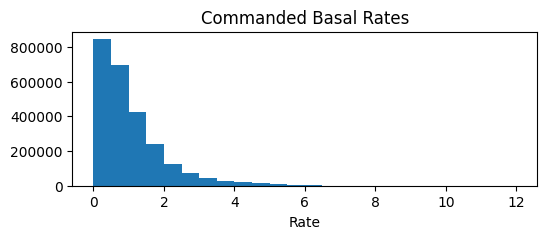

In [12]:
print('Commanded Basal Rate info: ')
print(df_basal.CommandedBasalRate.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Rate"); plt.title("Commanded Basal Rates")
plt.hist(df_basal.CommandedBasalRate, bins=np.arange(min(df_basal.CommandedBasalRate), max(df_basal.CommandedBasalRate) + 0.5, 0.5));

<div class="alert alert-block alert-info"> The maximum basal rate reached ~12 U/h. This equates to 1 U every 5 minutes.  </div>

### Distribution of Bolus Amounts

Commanded Basal Rate info: 
count    226685.000000
mean          2.140634
std           2.563934
min           0.000000
25%           0.540000
50%           1.215070
75%           2.714080
max          25.000002
Name: BolusAmount, dtype: float64


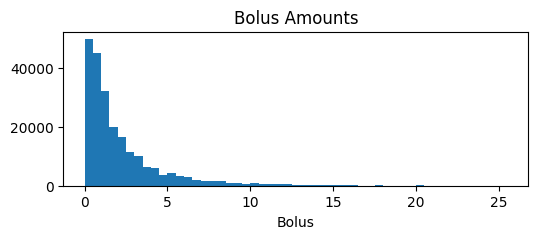

In [13]:
print('Commanded Basal Rate info: ')
print(df_bolus.BolusAmount.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Bolus"); plt.title("Bolus Amounts")
plt.hist(df_bolus.BolusAmount, bins=np.arange(min(df_bolus.BolusAmount), max(df_bolus.BolusAmount) + 0.5, 0.5));